Epoch 1/1000


c:\Program Files\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


233/233 ━━━━━━━━━━━━━━━━━━━━ 90s 374ms/step - accuracy: 0.4479 - loss: 1.0566 - val_accuracy: 0.5427 - val_loss: 0.9372
Epoch 2/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 83s 355ms/step - accuracy: 0.5814 - loss: 0.8911 - val_accuracy: 0.6640 - val_loss: 0.8194
Epoch 3/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 82s 354ms/step - accuracy: 0.7000 - loss: 0.7493 - val_accuracy: 0.7323 - val_loss: 0.6918
Epoch 4/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 80s 344ms/step - accuracy: 0.7964 - loss: 0.5667 - val_accuracy: 0.7825 - val_loss: 0.6074
Epoch 5/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 81s 346ms/step - accuracy: 0.8439 - loss: 0.4626 - val_accuracy: 0.8073 - val_loss: 0.5535
Epoch 6/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 81s 348ms/step - accuracy: 0.8682 - loss: 0.3884 - val_accuracy: 0.8124 - val_loss: 0.5482
Epoch 7/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 80s 343ms/step - accuracy: 0.8922 - loss: 0.3251 - val_accuracy: 0.8102 - val_loss: 0.5446
Epoch 8/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 80s 342ms/step - accuracy: 0.8944 - loss

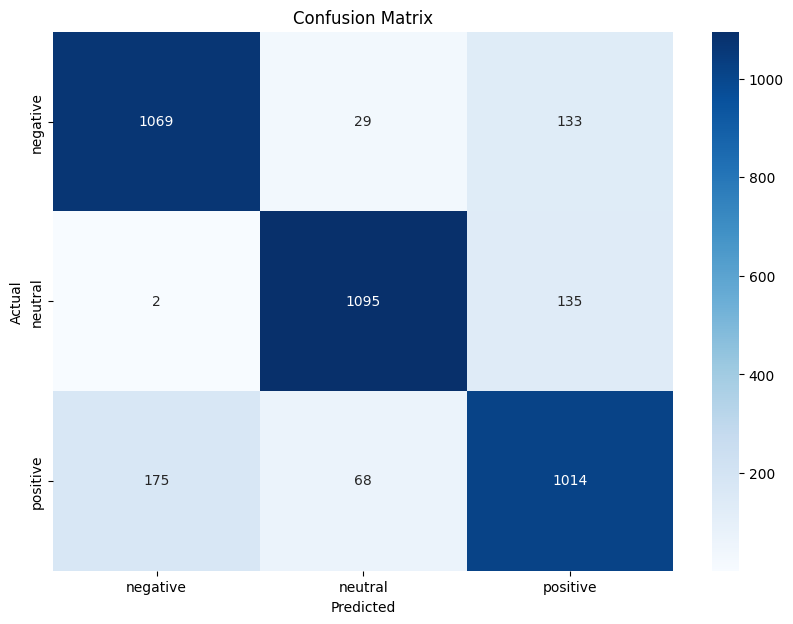

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler  # for oversampling
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Bidirectional, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

df = pd.read_csv('play_store_reviews.csv', encoding='utf-8')
new_df = df.drop(columns=['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion'])

def sentiment_conversion(row):
    if row['score'] == 3:
        return 'neutral'
    elif row['score'] > 3:
        return 'positive'
    elif row['score'] < 3:
        return 'negative'

# Apply sentiment conversion
new_df['Sentiment'] = new_df.apply(sentiment_conversion, axis=1)

new_df.head()
new_df['Sentiment'].value_counts()

# Separate input features and target labels
X = new_df['content'].values.astype(str)
y = new_df['Sentiment'].values

# Encode sentiment labels
le = LabelEncoder()
y = le.fit_transform(y)

# Tokenization and padding sequences for deep learning
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Oversample the dataset to balance the classes
ros = RandomOverSampler(random_state=42)
X_pad_res, y_res = ros.fit_resample(X_pad, y)

# Split the oversampled dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_pad_res, y_res, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=256, input_length=max_len))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 output units for 3 classes

# Compile the model
optimizer = Adam(learning_rate=1e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Custom callback for stopping when val_accuracy reaches 86%
class EarlyStopAtValAccuracy(Callback):
    def __init__(self, accuracy=0.86):
        super(EarlyStopAtValAccuracy, self).__init__()
        self.accuracy = accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.accuracy:
            print(f"\nValidation accuracy reached {self.accuracy * 100:.2f}%, stopping training.")
            self.model.stop_training = True

# Callbacks: EarlyStopping and ModelCheckpoint
early_stop_acc = EarlyStopAtValAccuracy(accuracy=0.85)

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_val, y_val), verbose=1,
                    callbacks=[early_stop_acc])

# Evaluate the model
y_pred = np.argmax(model.predict(X_val), axis=-1)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [7]:
import os

# Jalankan pip freeze dan simpan output ke file requirements.txt
os.system('pip freeze > requirements.txt')

print("requirements.txt telah dibuat!")


requirements.txt telah dibuat!
